This notebook contains topic modeling using PCA visulization and k-means clustering.

In [35]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd#gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [21]:
print(sklearn.__version__)

0.22.1


# vectorize doc (bow)

In [3]:
indus = pd.read_csv('master_industry.csv')

In [5]:
indus['gind'] = indus['gind'].astype(str)

In [7]:
indus['wanted1'] = indus['gind'].str.startswith('10', na=False)

In [8]:
indus['wanted2'] = indus['gind'].str.startswith('15', na=False)
indus['wanted3'] = indus['gind'].str.startswith('45', na=False)
indus['wanted4'] = indus['gind'].str.startswith('40', na=False)

In [9]:
indus_wanted = indus[(indus['wanted1']== True)|(indus['wanted2'] ==True) \
                        |(indus['wanted3'] ==True )|(indus['wanted4'] ==True )]

In [10]:
indus.head(10)

,gvkey,FDATE,permno,ma_ret,RET,vwret,FName,gind,wanted1,wanted2,wanted3,wanted4
0,12994,20100331,10001,0.006574,0.004792,-0.0036,0000950123-10-030755.txt,551020.0,False,False,False,False
1,12994,20110404,10001,-0.010405,0.002545,0.0009,0000950123-11-032614.txt,551020.0,False,False,False,False
2,12994,20120410,10001,-0.004503,-0.012281,-0.0185,0001193125-12-157390.txt,551020.0,False,False,False,False
3,12994,20130401,10001,0.034031,0.013726,-0.0057,0001193125-13-136685.txt,551020.0,False,False,False,False
4,12994,20140331,10001,-0.021659,0.007007,0.0097,0001193125-14-123966.txt,551020.0,False,False,False,False
5,12994,20150312,10001,-0.006624,0.000000,0.0128,0001144204-15-015657.txt,551020.0,False,False,False,False
6,12994,20160315,10001,0.007276,-0.010025,-0.0036,0001144204-16-088193.txt,551020.0,False,False,False,False
7,11903,20100114,10025,-0.030430,0.023926,0.0024,0001193125-10-006494.txt,151030.0,False,True,False,False
8,11903,20110114,10025,0.066290,0.066775,0.0069,0001193125-11-008295.txt,151030.0,False,True,False,False
9,11903,20120117,10025,0.034458,0.029080,0.0036,0001193125-12-013914.txt,151030.0,False,True,False,False


In [24]:
def categorize(x):
    
    if x.startswith('10'):
        cat = 'energy'
    elif x.startswith('15'):
        cat = 'material'
    elif x.startswith('45'):
        cat = 'IT'
    else:
        cat = 'finance'
        
    return cat

In [26]:
indus_wanted['category'] = indus_wanted['gind'].apply(lambda x: categorize(x))

/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
indus_wanted[indus_wanted['category'] == 'finance']

,gvkey,FDATE,permno,ma_ret,RET,vwret,FName,gind,wanted1,wanted2,wanted3,wanted4,category
80,12138,20100205,10138,-0.014425,0.012430,0.0029,0000950123-10-009025.txt,402030.0,False,False,False,True,finance
81,12138,20110208,10138,0.007117,0.003582,0.0048,0000950123-11-010348.txt,402030.0,False,False,False,True,finance
82,12138,20120203,10138,-0.014630,0.025065,0.0158,0001193125-12-038736.txt,402030.0,False,False,False,True,finance
83,12138,20130205,10138,-0.001402,0.009505,0.0107,0001113169-13-000010.txt,402030.0,False,False,False,True,finance
84,12138,20140204,10138,-0.001256,0.026563,0.0077,0001113169-14-000007.txt,402030.0,False,False,False,True,finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,64193,20160324,93131,0.015359,0.030924,0.0000,0001144204-16-089928.txt,401010.0,False,False,False,True,finance
37691,64193,20170324,93131,0.067777,0.066079,-0.0005,0001628280-17-002874.txt,401010.0,False,False,False,True,finance
37692,64193,20180321,93131,-0.007440,0.030928,-0.0006,0001628280-18-003446.txt,401010.0,False,False,False,True,finance
37693,64193,20190322,93131,0.031004,0.006410,-0.0217,0001437749-19-005481.txt,401010.0,False,False,False,True,finance


In [31]:
with open('indus_wanted.pkl', 'wb') as handle:
    pickle.dump(indus_wanted, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Starting here

In [10]:
import pickle 

with open('indus_wanted.pkl', 'rb') as handle:
    indus_wanted = pickle.load(handle)

indus_wanted

,gvkey,FDATE,permno,ma_ret,RET,vwret,FName,gind,wanted1,wanted2,wanted3,wanted4,category
7,11903,20100114,10025,-0.030430,0.023926,0.0024,0001193125-10-006494.txt,151030.0,False,True,False,False,material
8,11903,20110114,10025,0.066290,0.066775,0.0069,0001193125-11-008295.txt,151030.0,False,True,False,False,material
9,11903,20120117,10025,0.034458,0.029080,0.0036,0001193125-12-013914.txt,151030.0,False,True,False,False,material
10,11903,20130122,10025,-0.004012,0.000162,0.0048,0001193125-13-019043.txt,151030.0,False,True,False,False,material
11,11903,20140114,10025,0.012214,0.035475,0.0115,0001193125-14-010742.txt,151030.0,False,True,False,False,material
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37715,66228,20100728,93398,-0.110737,0.001770,-0.0082,0000943440-10-000447.txt,101020.0,True,False,False,False,energy
37716,66228,20110729,93398,-0.426273,-0.183333,-0.0056,0000943440-11-000404.txt,101020.0,True,False,False,False,energy
37717,66228,20120716,93398,-0.122059,-0.054348,-0.0031,0000785968-12-000030.txt,101020.0,True,False,False,False,energy
37718,66228,20130715,93398,-0.003624,-0.007389,0.0020,0000785968-13-000065.txt,101020.0,True,False,False,False,energy


In [11]:
#import pickle
with open('TFVects.pkl', 'rb') as handle:
    TFVects = pickle.load(handle)

In [12]:
type(TFVects)

scipy.sparse.csr.csr_matrix

In [13]:
TFVects.shape

(37720, 43150)

In [14]:
tf_arr = TFVects.toarray()

In [15]:
type(tf_arr)

numpy.ndarray

In [10]:
indus_wanted.index
tf_arr[list(indus_wanted.index)].shape

Int64Index([    7,     8,     9,    10,    11,    12,    33,    34,    35,
               36,
            ...
            37710, 37711, 37712, 37713, 37714, 37715, 37716, 37717, 37718,
            37719],
           dtype='int64', length=16411)

In [16]:
TFVects = tf_arr[list(indus_wanted.index)]

In [18]:
with open('TFVects_wanted.pkl', 'wb') as handle:
    pickle.dump(TFVects, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('TFVectorizer.pkl', 'rb') as handle:
    TFVectorizer = pickle.load(handle)


/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/daphne/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### 6 topics 

In [32]:
import time

start = time.time()
km = sklearn.cluster.KMeans(n_clusters=6, init='k-means++')
km.fit(TFVects)
print('time elapsed:', time.time()-start)


time elapsed: 3975.1330358982086


In [33]:
#And we look at the scores of this clustering
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

In [42]:
with open('km6.pkl', 'wb') as handle:
    pickle.dump(km, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open('km6.pkl', 'rb') as handle:
    km = pickle.load(handle)

The categories' colors are:
dict_items([('energy', 'blue'), ('material', 'red'), ('IT', 'orange'), ('finance', 'green')])


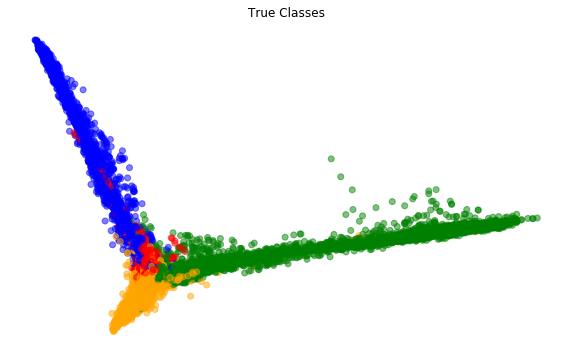

In [35]:
# plotting

PCA = sklearn.decomposition.PCA
#pca = PCA(n_components = 2).fit(TFVects.toarray())
pca = PCA(n_components = 2).fit(TFVects)
#reduced_data = pca.transform(TFVects.toarray())
reduced_data = pca.transform(TFVects)

colordict = {
 'energy':'blue',
'material':'red',
    'IT':'orange',
    'finance':'green'}
    

colors = [colordict[c] for c in indus_wanted['category']]
print("The categories' colors are:\n{}".format(colordict.items()))


fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [28]:
with open('pca.pkl', 'wb') as handle:
    pickle.dump(pca, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('reduced_data.pkl', 'wb') as handle:
    pickle.dump(reduced_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

The categories' colors are:
dict_items([('energy', 'blue'), ('material', 'red'), ('IT', 'orange'), ('finance', 'green')])


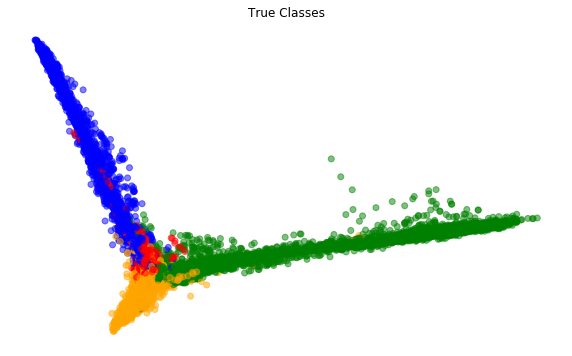

In [27]:
# plotting

PCA = sklearn.decomposition.PCA
#pca = PCA(n_components = 2).fit(TFVects.toarray())
pca = PCA(n_components = 2).fit(TFVects)
#reduced_data = pca.transform(TFVects.toarray())
reduced_data = pca.transform(TFVects)

colordict = {
 'energy':'blue',
'material':'red',
    'IT':'orange',
    'finance':'green'}
    

colors = [colordict[c] for c in indus_wanted['category']]
print("The categories' colors are:\n{}".format(colordict.items()))


fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [24]:
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(6):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 reinsurance
 premiums
 catastrophe
 lae
 accident
 underwriting
 written
 premium
 casualty
 ceded


Cluster 1:
 gas
 oil
 natural
 drilling
 proved
 properties
 wells
 crude
 exploration
 boe


Cluster 2:
 software
 subscription
 license
 cloud
 research
 solutions
 hardware
 vsoe
 licenses
 headcount


Cluster 3:
 research
 restructuring
 currency
 manufacturing
 solutions
 semiconductor
 software
 warranty
 pension
 percent


Cluster 4:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb


Cluster 5:
 mortgage
 oil
 gas
 unrealized
 ebitda
 crude
 coal
 aum
 distributions
 drilling




In [29]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

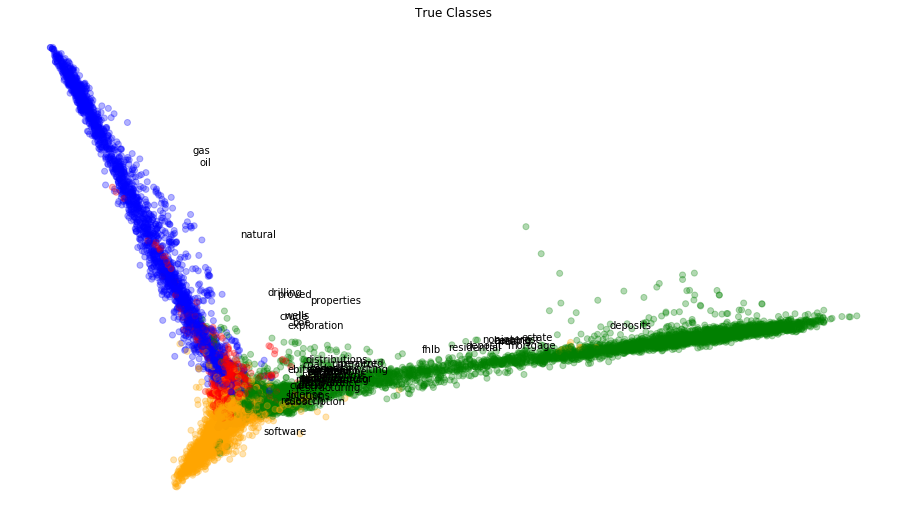

In [30]:
#adding features
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

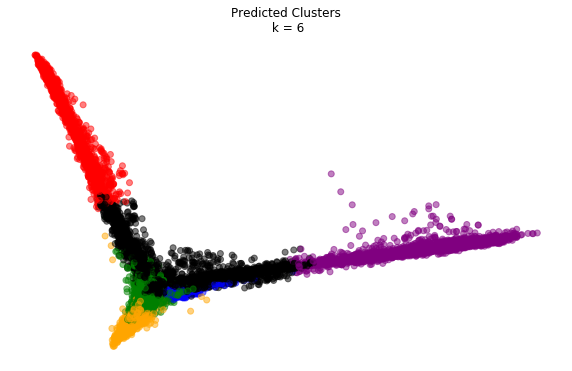

In [45]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange',3:'green',4:'purple', 5:'black'}
colors_p = [Cat_col[l] for l in km.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 6')
plt.show()

### 4 Topics

In [31]:
with open('km4.pkl', 'rb') as handle:
    km4 = pickle.load(handle)


In [32]:
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km4.cluster_centers_.argsort()[:, ::-1]
for i in range(4):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 gas
 oil
 natural
 drilling
 proved
 properties
 crude
 wells
 exploration
 boe


Cluster 1:
 reinsurance
 premiums
 catastrophe
 lae
 accident
 underwriting
 written
 premium
 casualty
 ceded


Cluster 2:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb


Cluster 3:
 software
 research
 solutions
 restructuring
 currency
 subscription
 license
 ebitda
 manufacturing
 percent




In [39]:
start = time.time()
km4 = sklearn.cluster.KMeans(n_clusters=4, init='k-means++')
km4.fit(TFVects)
print('time elapsed:', time.time()-start)


time elapsed: 6242.4488260746


In [41]:
with open('km4.pkl', 'wb') as handle:
    pickle.dump(km4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
#And we look at the scores of this clustering
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km4.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km4.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km4.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km4.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

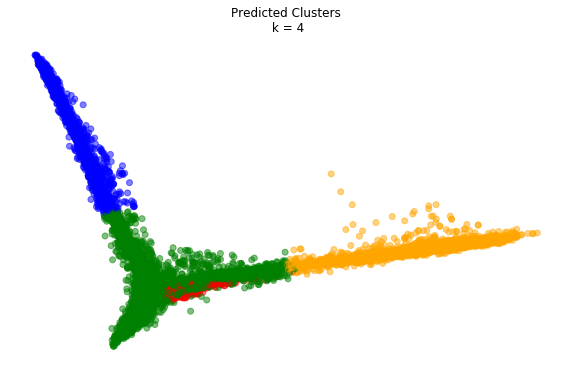

In [47]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange',3:'green'}
colors_p = [Cat_col[l] for l in km4.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

### 3 Topics

In [33]:
with open('km3.pkl', 'rb') as handle:
    km3 = pickle.load(handle)
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km3.cluster_centers_.argsort()[:, ::-1]
for i in range(3):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 software
 research
 solutions
 restructuring
 currency
 subscription
 reinsurance
 license
 ebitda
 premiums


Cluster 1:
 gas
 oil
 natural
 drilling
 proved
 properties
 crude
 wells
 exploration
 boe


Cluster 2:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb




In [48]:
start = time.time()
km3 = sklearn.cluster.KMeans(n_clusters=3, init='k-means++')
km3.fit(TFVects)
print('time elapsed:', time.time()-start)


time elapsed: 4863.359057188034


In [49]:
with open('km3.pkl', 'wb') as handle:
    pickle.dump(km3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
#And we look at the scores of this clustering
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km3.labels_)))

For our clusters:
Homogeneity: 0.298
Completeness: 0.484
V-measure: 0.369
Adjusted Rand Score: 0.163


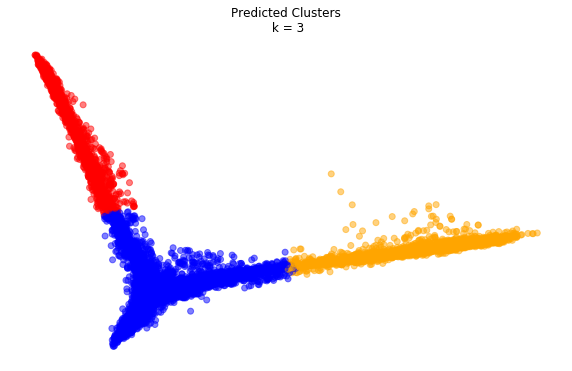

In [51]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange'}
colors_p = [Cat_col[l] for l in km3.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

### topics = 2

In [34]:
with open('km2.pkl', 'rb') as handle:
    km2 = pickle.load(handle)
#Now look at the distinguishing features in each cluster
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km2.cluster_centers_.argsort()[:, ::-1]
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 gas
 oil
 software
 natural
 research
 solutions
 restructuring
 currency
 subscription
 drilling


Cluster 1:
 deposits
 estate
 mortgage
 real
 earning
 bearing
 noninterest
 deposit
 residential
 fhlb




In [53]:
start = time.time()
km2 = sklearn.cluster.KMeans(n_clusters=2, init='k-means++')
km2.fit(TFVects)
print('time elapsed:', time.time()-start)
with open('km2.pkl', 'wb') as handle:
    pickle.dump(km2, handle, protocol=pickle.HIGHEST_PROTOCOL)

time elapsed: 5289.469854831696


In [54]:
#And we look at the scores of this clustering
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km2.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km2.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km2.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km2.labels_)))

For our clusters:
Homogeneity: 0.164
Completeness: 0.425
V-measure: 0.237
Adjusted Rand Score: 0.054


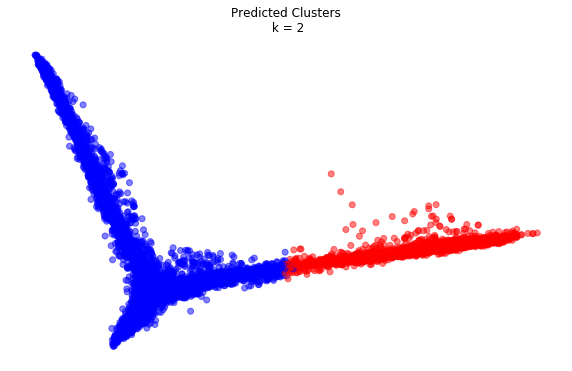

In [55]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange'}
colors_p = [Cat_col[l] for l in km2.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 2')
plt.show()

### topics = 5

In [ ]:
import time
start = time.time()
km5 = sklearn.cluster.KMeans(n_clusters=5, init='k-means++')
km5.fit(TFVects)

print('time elapsed:', time.time()-start)
with open('km5.pkl', 'wb') as handle:
    pickle.dump(km5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#And we look at the scores of this clustering
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(indus_wanted['category'], km5.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(indus_wanted['category'], km5.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(indus_wanted['category'], km5.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(indus_wanted['category'], km5.labels_)))

In [ ]:
#Now let us look at predicted clusters
Cat_col = {0:'blue',1:'red',2:'orange',3:'green',4:'purple'}
colors_p = [Cat_col[l] for l in km5.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 2')
plt.show()